In [38]:
import numpy as np
import sys
sys.path.append('/home/linkermann/Desktop/MA/opticalFlow/opticalFlowGAN')
import tflib as lib
from tflib.save_images import save_images
import tflib.SINTELdataFlow as sintel
import tflib.flow_handler as fh
#import cv2
from IPython.core.display import Image, display
import PIL
%matplotlib inline
import matplotlib.pyplot as plt

def show(image): # to show np array as image
    a = (image).astype(np.uint8)
    display(PIL.Image.fromarray(a))

BATCH_SIZE = 10 # Batch size
IM_DIM = 300
OUT_DIM_FLOW = IM_DIM*IM_DIM*2

gen = sintel.load_train_gen(BATCH_SIZE,(TARGET_SIZE, TARGET_SIZE, 3))
_data, _flow = next(gen)
# images: (n, 6144) -- 3072 + 3072 = two images for 32
# flows: (n, 4096) -- 2048 + 2048 = two flows for 32
            
outpath = "/home/linkermann/Desktop/MA/opticalFlow/opticalFlowGAN/data/gentest/"

flows = _flow[0] # first from batch
flow1 = flows[0:OUT_DIM_FLOW] # (2048,) for 32
flow2 = flows[OUT_DIM_FLOW:] # (2048,) for 32
flow1 = flow1.reshape(TARGET_SIZE,TARGET_SIZE,2)
flow2 = flow2.reshape(TARGET_SIZE,TARGET_SIZE,2)

# save flow               # write_flo_file(flow, filename)  
# filename must be string and end in .flo. Flow must be in (w,h,2) format
# fh.write_flo_file(flow1, outpath+'sample_sintel_flow.flo')  
# load flow from file     # read_flo_file(filename)
# flowfile = fh.read_flo_file(outpath+"sample_sintel_flow.flo")
flow_ims= _flow[:,OUT_DIM_FLOW:]
flowimages = []

# show flow               # computeImg(flow)
for i in range(0, BATCH_SIZE):
    flowimg = fh.computeImg(flow_ims[i].reshape((IM_DIM,IM_DIM,2)))    # (200, 200, 3) # now color img!! :)
    # show(flowimg) 
    flowimage_T = np.transpose(flowimg, [2,0,1])  #  (3, 200, 200)
    flowimages.append(flowimage_T)
# write flow as png
# cv2.imwrite(outpath+'sample_sintel_flow2.png', flowimg) # for this delete inversion in flow handler
# visualize
#cv2.imshow(outpath+'sample_sintel_flow2.flo',flowimg)  # for this delete inversion in flow handler
#cv2.waitKey() # needed, whatever it does
samples2show = np.array(flowimages)

save_images(samples2show.reshape((BATCH_SIZE,3,TARGET_SIZE,TARGET_SIZE)), outpath+"flowimagesBATCH.jpg")


load lists from files
Creating train generator with 1018 samples.
max flow: 12.6359 flow range: u = -12.162 .. 10.598; v = -1.790 .. 3.828

max flow: 53.4527 flow range: u = -16.237 .. 52.790; v = -36.095 .. 29.793

max flow: 22.9852 flow range: u = -5.061 .. 19.655; v = -15.425 .. 5.788

max flow: 29.5782 flow range: u = -22.890 .. 24.952; v = -17.499 .. 20.096

max flow: 42.2424 flow range: u = -35.793 .. 8.086; v = -23.317 .. 36.957

max flow: 12.2315 flow range: u = -0.266 .. 0.576; v = -12.231 .. -0.117

max flow: 98.3121 flow range: u = -10.664 .. 95.136; v = -49.506 .. 3.267

max flow: 96.4583 flow range: u = -86.781 .. 3.308; v = -7.738 .. 73.410

max flow: 101.9889 flow range: u = -97.427 .. -7.712; v = -42.269 .. 16.352

max flow: 3.5891 flow range: u = -2.542 .. 2.465; v = -2.762 .. 2.709



In [6]:
from glob import glob
from os.path import join, isfile


def get_category_from_path(path):
    parts = path.split('/')
    return parts[-2]

root = '/home/linkermann/Desktop/MA/data/SINTEL/training/'
flow_root = join(root, 'flow')
image_root = join(root, 'clean')
validation_image_root = join(root, 'final')
flow_paths = join(root, 'flow/*/*.flo')
file_list = glob(flow_paths)
sorted_file_list= sorted(file_list)

lenli = len(sorted_file_list)
for i, file in enumerate(sorted_file_list):
    nextelem = sorted_file_list[(i+1)%lenli]
    # if(not(get_category_from_path(file) == get_category_from_path(nextelem))):
        # print("Next category @ "+ str(i) + "\n")

In [44]:
import os, sys
sys.path.append('/home/linkermann/Desktop/MA/opticalFlow/opticalFlowGAN')
import time
import numpy as np
import tensorflow as tf
from IPython.core.display import Image, display
import PIL
import tflib as lib
import tflib.save_images as si
import tflib.flow_handler as fh
import tflib.SINTELdataFlow as sintel
from skimage.measure import compare_ssim as ssim

DIM = 64 # This overfits substantially; you're probably better off with 64 # or 128?
BATCH_SIZE = 64 # Batch size
ITERS = 100000 # How many generator iterations to train for # 200000 takes too long
IM_DIM = 64 # number of pixels along x and y (square assumed)
SQUARE_IM_DIM = IM_DIM*IM_DIM # 32*32 = 1024
OUTPUT_DIM = IM_DIM*IM_DIM*3 # Number of pixels (3*32*32) - rgb color
OUTPUT_DIM_FLOW = IM_DIM*IM_DIM*2 # Number of pixels (2*32*32) - uv direction

cond_data_int = tf.placeholder(tf.int32, shape=[BATCH_SIZE, OUTPUT_DIM]) # conditional input for both G and D
cond_data = 2*((tf.cast(cond_data_int, tf.float32)/255.)-.5) #normalized [0,1]!
real_data_int = tf.placeholder(tf.int32, shape=[BATCH_SIZE, OUTPUT_DIM_FLOW]) # real data is flow now! dim 2!
real_data = 2*((tf.cast(real_data_int, tf.float32)/255.)-.5) #normalized [0,1]!

def mse(x, y):
    return np.linalg.norm(x - y)

def show(image): # to show np array as image
    a = (image).astype(np.uint8)
    display(PIL.Image.fromarray(a))

# Dataset iterators
gen = sintel.load_train_gen(BATCH_SIZE, (IM_DIM,IM_DIM,3)) # batch size, im size
dev_gen = sintel.load_test_gen(BATCH_SIZE, (IM_DIM,IM_DIM,3))

# For generating samples: define fixed noise and conditional input
fixed_cond_samples, fixed_flow_samples = next(gen)  # shape: (batchsize, 3072) 
fixed_cond_data_int = fixed_cond_samples[:,0:OUTPUT_DIM]  # earlier frame as condition  # shape (64,3072) uint8..
fixed_real_data_int = fixed_flow_samples[:,0:OUTPUT_DIM_FLOW] # earlier flow as comparison to result of generator  # shape (64,2048)
fixed_cond_data_normalized = 2*((tf.cast(fixed_cond_data_int, tf.float32)/255.)-.5) #normalized [0,1]! 
fixed_noise = tf.constant(np.random.normal(size=(BATCH_SIZE, SQUARE_IM_DIM)).astype('float32'))  # for additional channel
#fixed_noise_samples = Generator(BATCH_SIZE, fixed_cond_data_normalized, noise=fixed_noise) # Generator(n_samples,conds, noise):

samples = (np.random.rand(BATCH_SIZE, OUTPUT_DIM_FLOW) *2) -1  # range -1 bis 1
     
flowimages = []    
for i in range(0, BATCH_SIZE):
    flowimg = fh.computeImg(samples[i].reshape((IM_DIM,IM_DIM,2)))    # (200, 200, 3) # now color img!! :)
    #show(flowimg) 
    flowimage_T = np.transpose(flowimg, [2,0,1])  #  (3, 200, 200)
    flowimages.append(fixed_cond_data_int[i])
    flowimages.append(flowimage_T.flatten())
samples2show = np.array(flowimages)

outpath = "/home/linkermann/Desktop/MA/opticalFlow/opticalFlowGAN/data/gentest/"
si.save_images(samples2show.reshape((2*BATCH_SIZE, 3, IM_DIM, IM_DIM)), outpath+'samples_0000.jpg') # also save as .flo?

load lists from files
load lists from files
Creating train generator with 1018 samples.
max flow: 1.4072 flow range: u = -0.999 .. 1.000; v = -1.000 .. 1.000

max flow: 1.4096 flow range: u = -1.000 .. 1.000; v = -1.000 .. 0.999

max flow: 1.3940 flow range: u = -0.999 .. 1.000; v = -1.000 .. 0.999

max flow: 1.4008 flow range: u = -0.999 .. 0.999; v = -1.000 .. 0.999

max flow: 1.4035 flow range: u = -0.999 .. 0.999; v = -0.999 .. 1.000

max flow: 1.3959 flow range: u = -1.000 .. 1.000; v = -1.000 .. 1.000

max flow: 1.4004 flow range: u = -1.000 .. 0.999; v = -1.000 .. 1.000

max flow: 1.4042 flow range: u = -0.999 .. 1.000; v = -0.999 .. 1.000

max flow: 1.4133 flow range: u = -1.000 .. 1.000; v = -0.999 .. 0.998

max flow: 1.3948 flow range: u = -0.998 .. 1.000; v = -1.000 .. 0.999

max flow: 1.3940 flow range: u = -1.000 .. 1.000; v = -0.999 .. 1.000

max flow: 1.3943 flow range: u = -1.000 .. 1.000; v = -1.000 .. 1.000

max flow: 1.4033 flow range: u = -1.000 .. 1.000; v = -1.000

max flow: 1.3778 flow range: u = -1.000 .. 0.999; v = -1.000 .. 1.000



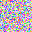

In [20]:
import numpy as np

samples = (np.random.rand(BATCH_SIZE, OUTPUT_DIM_FLOW) *2) -1
# samples_255 = ((samples+1.)*(255./2)).astype('int32') #back to [0,255] 
colorimg = fh.computeImg(samples[0].reshape(IM_DIM,IM_DIM,2))   # (32, 32, 3) # now color img!! :)  uint8 now?
show(colorimg) 

In [51]:
import os, sys
sys.path.append('/home/linkermann/Desktop/MA/opticalFlow/opticalFlowGAN')
import time
import numpy as np
import tensorflow as tf
from IPython.core.display import Image, display
import PIL
import tflib as lib
import tflib.save_images as si
import tflib.flow_handler as fh
import tflib.SINTELdataFlow as sintel
from skimage.measure import compare_ssim as ssim

DIM = 64 # This overfits substantially; you're probably better off with 64 # or 128?
BATCH_SIZE = 64 # Batch size
ITERS = 100000 # How many generator iterations to train for # 200000 takes too long
IM_DIM = 32 # number of pixels along x and y (square assumed)
SQUARE_IM_DIM = IM_DIM*IM_DIM # 32*32 = 1024
OUTPUT_DIM = IM_DIM*IM_DIM*3 # Number of pixels (3*32*32) - rgb color
OUTPUT_DIM_FLOW = IM_DIM*IM_DIM*2 # Number of pixels (2*32*32) - uv direction

cond_data_int = tf.placeholder(tf.int32, shape=[BATCH_SIZE, OUTPUT_DIM]) # conditional input for both G and D
cond_data = 2*((tf.cast(cond_data_int, tf.float32)/255.)-.5) #normalized [0,1]!
real_data_int = tf.placeholder(tf.int32, shape=[BATCH_SIZE, OUTPUT_DIM_FLOW]) # real data is flow now! dim 2!
real_data = 2*((tf.cast(real_data_int, tf.float32)/255.)-.5) #normalized [0,1]!

def mse(x, y):
    return np.linalg.norm(x - y)

def show(image): # to show np array as image
    a = (image).astype(np.uint8)
    display(PIL.Image.fromarray(a))

# Dataset iterators
gen = sintel.load_train_gen(BATCH_SIZE, (IM_DIM,IM_DIM,3)) # batch size, im size
dev_gen = sintel.load_test_gen(BATCH_SIZE, (IM_DIM,IM_DIM,3))

# For generating samples: define fixed noise and conditional input
fixed_cond_samples, fixed_flow_samples = next(gen)  # shape: (batchsize, 3072) 
fixed_cond_data_int = fixed_cond_samples[:,0:OUTPUT_DIM]  # earlier frame as condition  # shape (64,3072) uint8..
fixed_real_data_int = fixed_flow_samples[:,0:OUTPUT_DIM_FLOW] # earlier flow as comparison to result of generator  # shape (64,2048)
fixed_cond_data_normalized = 2*((tf.cast(fixed_cond_data_int, tf.float32)/255.)-.5) #normalized [0,1]! 
fixed_noise = tf.constant(np.random.normal(size=(BATCH_SIZE, SQUARE_IM_DIM)).astype('float32'))  # for additional channel
#fixed_noise_samples = Generator(BATCH_SIZE, fixed_cond_data_normalized, noise=fixed_noise) # Generator(n_samples,conds, noise):

samples = (np.random.rand(BATCH_SIZE, OUTPUT_DIM_FLOW) *2) -1  # range -1 bis 1
     
flowimages = []    
for i in range(0, BATCH_SIZE):
    flowimg = fh.computeImg(samples[i].reshape((IM_DIM,IM_DIM,2)))    # (200, 200, 3) # now color img!! :)
    #show(flowimg) 
    flowimage_T = np.transpose(flowimg, [2,0,1])  #  (3, 200, 200)
    
    flowimg_real = fh.computeImg(fixed_real_data_int[i].reshape((IM_DIM,IM_DIM,2)))    # (200, 200, 3) # now color img!! :)
    # show(flowimg_real) 
    flowimage_real_T = np.transpose(flowimg_real, [2,0,1])  #  (3, 200, 200)
    
    flowimages.append(flowimage_real_T.flatten())
    flowimages.append(flowimage_T.flatten())
samples2show = np.array(flowimages)

outpath = "/home/linkermann/Desktop/MA/opticalFlow/opticalFlowGAN/data/gentest/"
si.save_images(samples2show.reshape((2*BATCH_SIZE, 3, IM_DIM, IM_DIM)), outpath+'samples_0003.jpg') # also save as .flo?

load lists from files
load lists from files
Creating train generator with 1018 samples.
max flow: 1.3666 flow range: u = -0.999 .. 0.999; v = -0.998 .. 0.995

max flow: 1.3203 flow range: u = -0.768 .. -0.566; v = 0.788 .. 1.108

max flow: 1.3857 flow range: u = -0.999 .. 1.000; v = -0.997 .. 0.999

max flow: 20.4775 flow range: u = -4.202 .. 1.950; v = 0.657 .. 20.450

max flow: 1.3900 flow range: u = -0.998 .. 0.998; v = -0.998 .. 0.999

max flow: 38.8107 flow range: u = -17.211 .. -0.354; v = -36.313 .. 1.011

max flow: 1.3870 flow range: u = -0.999 .. 0.998; v = -0.999 .. 0.998

max flow: 18.2470 flow range: u = -2.404 .. 15.312; v = -17.125 .. 1.989

max flow: 1.3958 flow range: u = -0.994 .. 0.998; v = -0.999 .. 0.998

max flow: 0.6977 flow range: u = -0.698 .. -0.560; v = 0.000 .. 0.001

max flow: 1.3724 flow range: u = -0.997 .. 1.000; v = -0.999 .. 1.000

max flow: 1.7997 flow range: u = -1.702 .. -1.538; v = 0.526 .. 0.657

max flow: 1.3854 flow range: u = -0.998 .. 0.999; v 